# How to add an adapter

## What is an adapter?
Adapters are functions organized in the `attachments.adapt` namespace.

The `@adapter` decorator is used to mark a function as an adapter and register it in the `attachments.adapt` namespace.
This will also make it automatically available in `Attachments("path/to/file").name_of_the_adapter()`.
You can pass additional parameters to the adapter function, but the first parameter is required to be the `input_obj`.

### Example of an adapter
If we want to add an adapter called `mysupersdk` that allows us to use Attachments with mysupersdk, we can do the following:

```python
@adapter
def mysupersdk(input_obj: Union[Attachment, AttachmentCollection], prompt: str = "") -> List[Dict[str, Any]]:
    ...
```

Notice that the output in this case can be anything (that is the point of adapters).
In the case of `mysupersdk`, the output would be a list of dictionaries with string keys and any values.

Throughout this tutorial we will use the `agno` library as an example. This means we will develop
an adapter that allows us to use Attachments with agno. For agno, we may want to name the adapter `agno`.

Like this:

```python
@adapter
def agno(input_obj: Union[Attachment, AttachmentCollection], prompt: str = ""):
    ...
```
We are not quite sure yet what the output will be, but we will find out later.

## How agno usually works

This is from agno's documentation: https://docs.agno.com/agents/multimodal. 

In agno, you create an Agent object, and then when calling the agent you can
pass it an image using the Image object defined in the agno.media module.
For audio, you can use the Audio object defined in the agno.media module, and for 
video, you can use the Video object defined in the agno.media module. Video is supported
by the Gemini models, and audio can be given to a few models including Gemini and OpenAI's
gpt-4o-audio-preview.

To keep things simple, we will only focus on images in this tutorial.

### Example of how to use agno

In this example, we have a simple agent that would look at the provided image and
search online for the latest news about it.

In [1]:
from agno.agent import Agent as agnoAgent
from agno.media import Image as agnoImage
from agno.models.openai import OpenAIChat
from agno.tools.duckduckgo import DuckDuckGoTools

agent = agnoAgent(
    model=OpenAIChat(id="gpt-4.1-nano"),
    tools=[DuckDuckGoTools()],
    markdown=True,
)

response = agent.run(
    "Tell me about this image and give me the latest news about it.",
    images=[
        agnoImage(
            url="https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg"
        )
    ],
    stream=False  # No streaming
)
response.content

"### About the Image:\nThe image depicts the Golden Gate Bridge, an iconic suspension bridge located in San Francisco, California. It connects San Francisco to Marin County across the Golden Gate Strait, which is approximately a mile wide. The bridge is renowned for its striking International Orange color and Art Deco design. It was completed in 1937 and is considered one of the most recognizable symbols of San Francisco and the United States.\n\n### Latest News:\n1. **Construction and Safety Improvements**: Efforts are ongoing to enhance safety measures, such as the completion of physical suicide deterrent nets to prevent suicides on the bridge. These nets are being installed with recent reports indicating progress.\n2. **Traffic and Events**: There have been recent disruptions due to protests, but the bridge has been reopened to traffic afterward.\n3. **Other Developments**: The Golden Gate Bridge's response to safety reports and maintenance updates continue to be key focus areas.\n\

In [2]:
from IPython.display import Markdown
Markdown(response.content)

### About the Image:
The image depicts the Golden Gate Bridge, an iconic suspension bridge located in San Francisco, California. It connects San Francisco to Marin County across the Golden Gate Strait, which is approximately a mile wide. The bridge is renowned for its striking International Orange color and Art Deco design. It was completed in 1937 and is considered one of the most recognizable symbols of San Francisco and the United States.

### Latest News:
1. **Construction and Safety Improvements**: Efforts are ongoing to enhance safety measures, such as the completion of physical suicide deterrent nets to prevent suicides on the bridge. These nets are being installed with recent reports indicating progress.
2. **Traffic and Events**: There have been recent disruptions due to protests, but the bridge has been reopened to traffic afterward.
3. **Other Developments**: The Golden Gate Bridge's response to safety reports and maintenance updates continue to be key focus areas.

Would you like more detailed insights on a particular aspect?

## Our goal

The goal is to create an adapter that allows us to use Attachments with agno.
We would like it to work like this:

```python
response = agent.run(
    **Attachments("https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg").
                      agno("Tell me about this image and give me the latest news about it."),
    stream=False  # No streaming
)
response.content
```

The main benefit of this would be that we would benefit from Attachments' capabilities to load
a wide variety of files into images and text for us. Using this, we will be able to provide
PDFs, PPTX, DOCX, SVG (as images), webpages (rendered and text), etc. to agno.


## Exploring agno's Image Object for Attachment Adapter Development

Now that we understand how agno works, let's explore the Image object 
to understand how to build our attachment adapter.

### Examining the Image Object Structure
Let's create an Image object and examine its structure:

In [3]:
img = agnoImage(url="https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg")
type(img)

agno.media.Image

Let's check what attributes the Image object has:

In [4]:
dir(img)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_computed_fields__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_setattr_handl

Now let's examine the Image object's fields to understand its structure:

In [5]:
img.model_fields.keys()

/tmp/ipykernel_4054344/2098599573.py:1: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  img.model_fields.keys()


dict_keys(['url', 'filepath', 'content', 'format', 'detail', 'id'])

Perfect! We can see the Image object has fields like 'url', 'filepath', 'content', 'format', 'detail', and 'id'.
Let's explore what these fields contain:

In [6]:
print("URL:", img.url)
print("Filepath:", img.filepath)
print("Content:", img.content)
print("Format:", img.format)
print("Detail:", img.detail)
print("ID:", img.id)

URL: https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg
Filepath: None
Content: None
Format: None
Detail: None
ID: None


Great! So agno's Image object can be created with:
- `url`: A URL pointing to an image
- `filepath`: A local file path
- `content`: Raw image bytes
- `format`: Image format (png, jpeg, etc.)
- `detail`: Level of detail for processing
- `id`: Optional identifier

Let's experiment with creating Image objects in different ways:

## Experimenting with agno Image Creation

Let's try creating agno Images with different input methods to understand what works:

In [7]:
from agno.media import Image as AgnoImage
import base64

# Method 1: Create with URL
print("=== Method 1: URL ===")
img_url = AgnoImage(url="https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg")
print("URL Image:", img_url)
print("Has URL:", bool(img_url.url))

=== Method 1: URL ===
URL Image: url='https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg' filepath=None content=None format=None detail=None id=None
Has URL: True


In [8]:
# Method 2: Create with raw bytes content
print("\n=== Method 2: Raw Bytes ===")
# Let's create a tiny 1x1 pixel PNG for testing
sample_base64 = "iVBORw0KGgoAAAANSUhEUgAAAAEAAAABCAYAAAAfFcSJAAAADUlEQVR42mP8/5+hHgAHggJ/PchI7wAAAABJRU5ErkJggg=="
content_bytes = base64.b64decode(sample_base64)
img_content = AgnoImage(content=content_bytes)
print("Content Image:", img_content)
print("Has content:", bool(img_content.content))


=== Method 2: Raw Bytes ===
Content Image: url=None filepath=None content=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x01\x00\x00\x00\x01\x08\x06\x00\x00\x00\x1f\x15\xc4\x89\x00\x00\x00\rIDATx\xdac\xfc\xff\x9f\xa1\x1e\x00\x07\x82\x02\x7f=\xc8H\xef\x00\x00\x00\x00IEND\xaeB`\x82' format=None detail=None id=None
Has content: True


In [9]:
# Method 3: What about data URLs? (base64 encoded images with data: prefix)
print("\n=== Method 3: Data URL ===")
data_url = f"data:image/png;base64,{sample_base64}"
img_data_url = AgnoImage(url=data_url)
print("Data URL Image:", img_data_url)
print("URL field contains:", img_data_url.url[:50] + "..." if len(img_data_url.url) > 50 else img_data_url.url)


=== Method 3: Data URL ===
Data URL Image: url='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAEAAAABCAYAAAAfFcSJAAAADUlEQVR42mP8/5+hHgAHggJ/PchI7wAAAABJRU5ErkJggg==' filepath=None content=None format=None detail=None id=None
URL field contains: data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAEA...


Excellent! Now we understand that agno Images can handle:
1. **Regular URLs** - Direct links to images
2. **Raw bytes** - Binary image data
3. **Data URLs** - Base64-encoded images with data: prefix

This is important because Attachments stores images as base64 strings, which we can convert to any of these formats.

## Understanding Attachments Image Format

Now let's look at how Attachments stores images and see what we need to convert:

In [10]:
from attachments import Attachments

Create an attachment with an image:

In [11]:
sample_attachments = Attachments("https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg")

Get the underlying Attachment object (this is what adapters work with):

In [12]:
sample_attachment = sample_attachments.attachments[0]  # Get the first (and only) attachment
sample_attachment

Attachment(path='https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg', text=136 chars, images=[1 imgs: data:image/png;base64,iVBORw0K...5ErkJggg==], pipeline=['url_to_response', 'morph_to_detected_type', 'image_to_pil', 'watermark', 'AdditivePipeline(images ...])

In [13]:
# Let's examine what the attachment contains
print("Text content length:", len(sample_attachment.text))

Text content length: 136


In [14]:
print("Number of images:", len(sample_attachment.images))

Number of images: 1


In [15]:
print("Text preview:", sample_attachment.text[:200] + "..." if len(sample_attachment.text) > 200 else sample_attachment.text)

Text preview: 
## File Info

- **Content Type**: image/jpeg
- **Status Code**: 200
- **Format**: JPEG
- **Size**: 3264 × 2448 pixels
- **Mode**: RGB





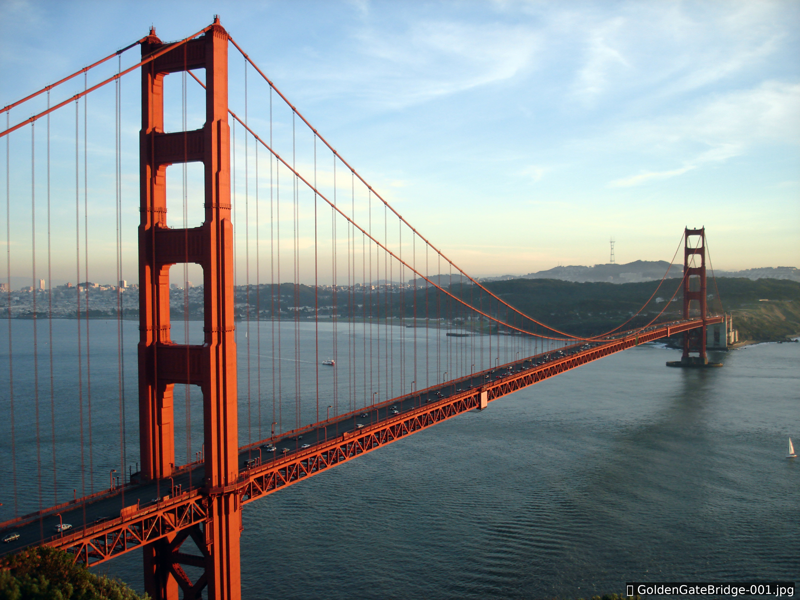

In [16]:
from IPython.display import HTML
HTML(f"<img src='{sample_attachment.images[0]}'>")

In [17]:
# Now let's look at how the image is stored
if sample_attachment.images:
    img_data = sample_attachment.images[0]
    print("Image data type:", type(img_data))
    print("Image data length:", len(img_data))
    print("Starts with 'data:image/':", img_data.startswith('data:image/'))
    print("First 50 characters:", img_data[:50])

Image data type: <class 'str'>
Image data length: 930866
Starts with 'data:image/': True
First 50 characters: data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAA


Perfect! Now we can see that:
- Attachments stores images as **data URL strings** (starting with 'data:image/')
- These are base64-encoded images with proper MIME type prefixes
- This format is **directly compatible** with agno's Image URL field!

**Important Note**: This tutorial works with the underlying `Attachment` objects (lowercase 'a'), 
not the high-level `Attachments` class. Adapters receive `Attachment` objects as input.

## Testing the Conversion

Let's test if we can directly use Attachments image data with agno:

Agno Image created successfully: url='' filepath=None content=None format=None detail=None id=None
Image URL field (first 100 chars): data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAIAAAAVFBUnAAEAAElEQVR4nEz9W8+2a3YdCI0x5/2ufa...

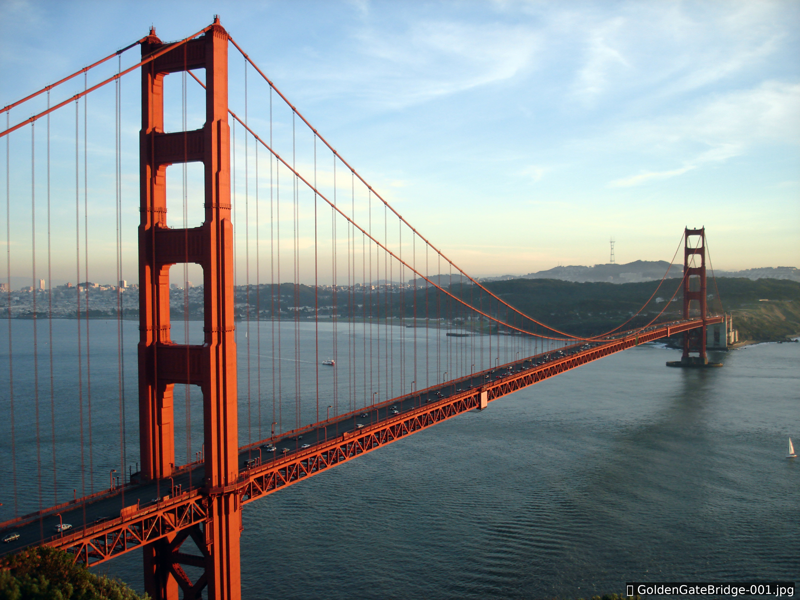

In [18]:
# Take the image data from Attachments
img_data = sample_attachment.images[0]

# Create an agno Image with it
agno_img = AgnoImage(url=img_data)
print("Agno Image created successfully:", agno_img)
print("Image URL field (first 100 chars):", agno_img.url[:100] + "...")

🎉 **Success!** The conversion works perfectly. Attachments' data URL format is directly compatible with agno's Image objects.

## Multiple attachments

It is very easy to move from a single attachment to a collection of attachments.
The object instantiated by Attachments will always have `.images` and `.text` attributes.
In the case of multiple attachments, these will be pre-concatenated.

So we can use the same API for both single and multiple attachments. 

Here is a quick example of that:

In [19]:
att = Attachments("https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg",
                  "https://upload.wikimedia.org/wikipedia/commons/2/2c/Llama_willu.jpg")
att

Attachments([jpg(136chars, 1imgs, img: data:image/png;base64,iVBORw0K...5ErkJggg==), jpg(134chars, 1imgs, img: data:image/png;base64,iVBORw0K...lFTkSuQmCC)])

In [20]:
len(att.images)

2

In [21]:
print(att.text)

📄 Processing Summary: 2 files processed, 2 images extracted

## https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg


## File Info

- **Content Type**: image/jpeg
- **Status Code**: 200
- **Format**: JPEG
- **Size**: 3264 × 2448 pixels
- **Mode**: RGB



---

## https://upload.wikimedia.org/wikipedia/commons/2/2c/Llama_willu.jpg


## File Info

- **Content Type**: image/jpeg
- **Status Code**: 200
- **Format**: JPEG
- **Size**: 480 × 589 pixels
- **Mode**: RGB





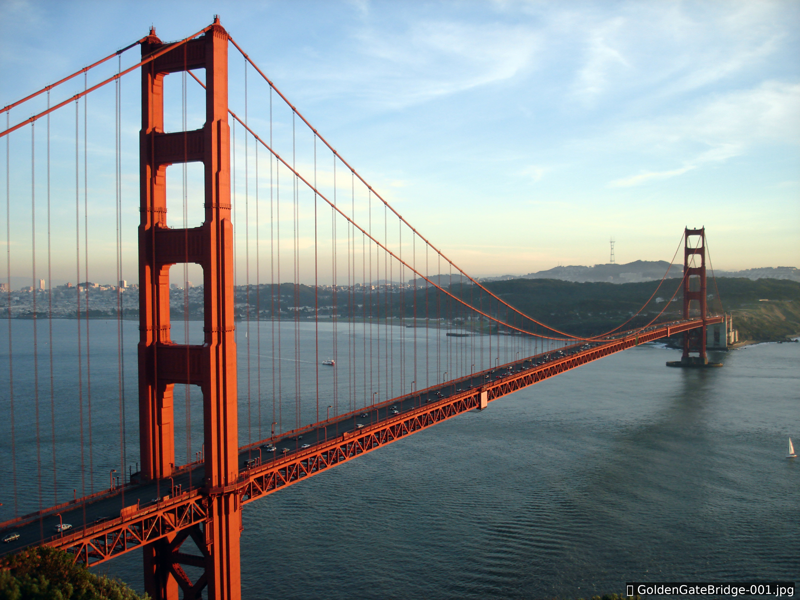
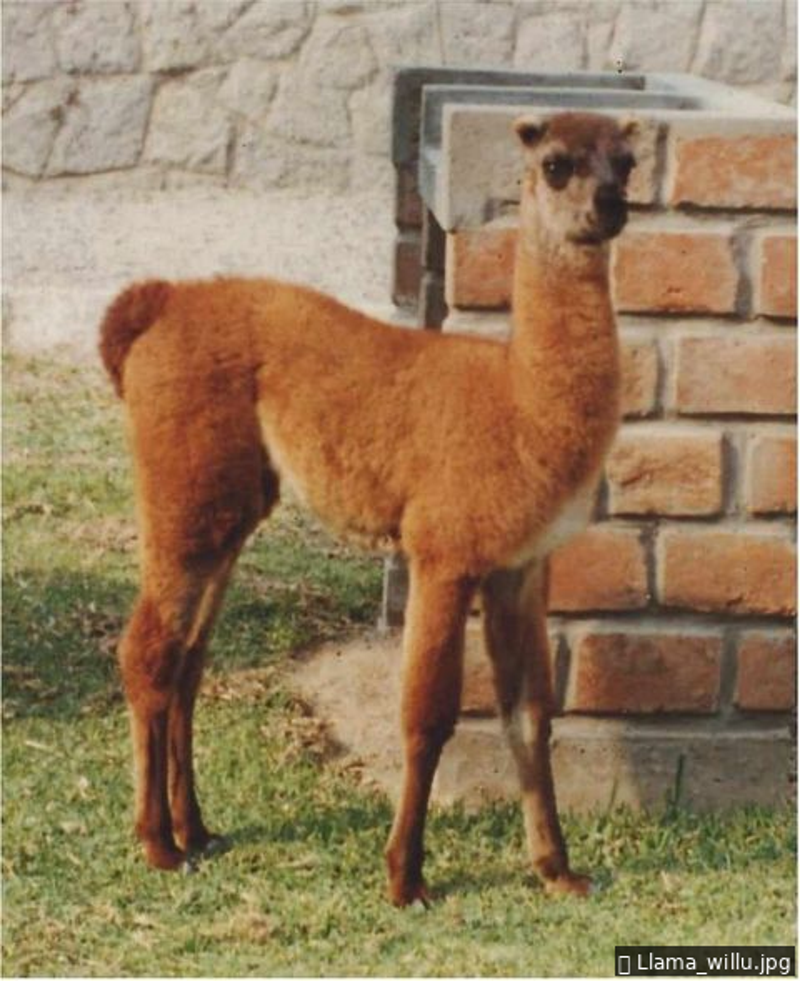

In [22]:
from IPython.display import HTML
HTML(f"<img src='{att.images[0]}' height='200'><img src='{att.images[1]}' height='200'>")

And so we can easily create a list of Agno Images:

[Image(url='', filepath=None, content=None, format=None, detail=None, id=None),
 Image(url='', filepath=None, content=None, format=None, detail=None, id=None)]
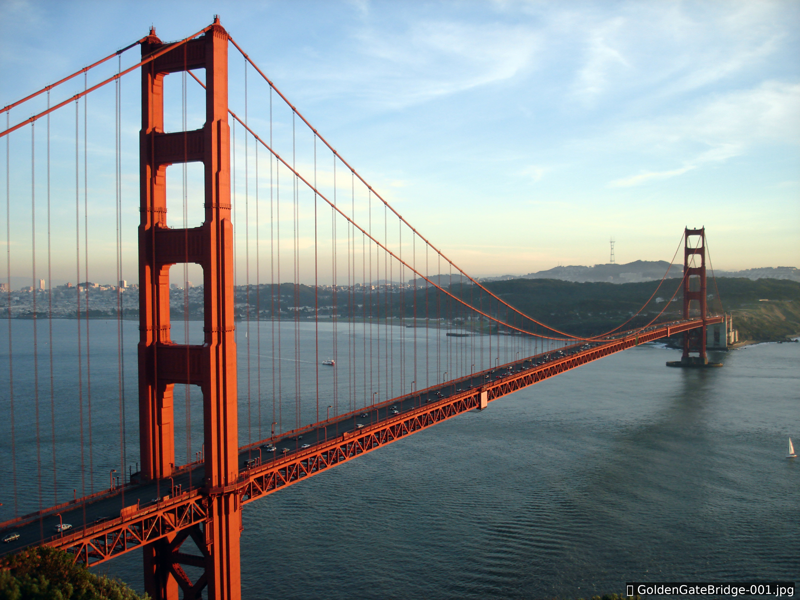
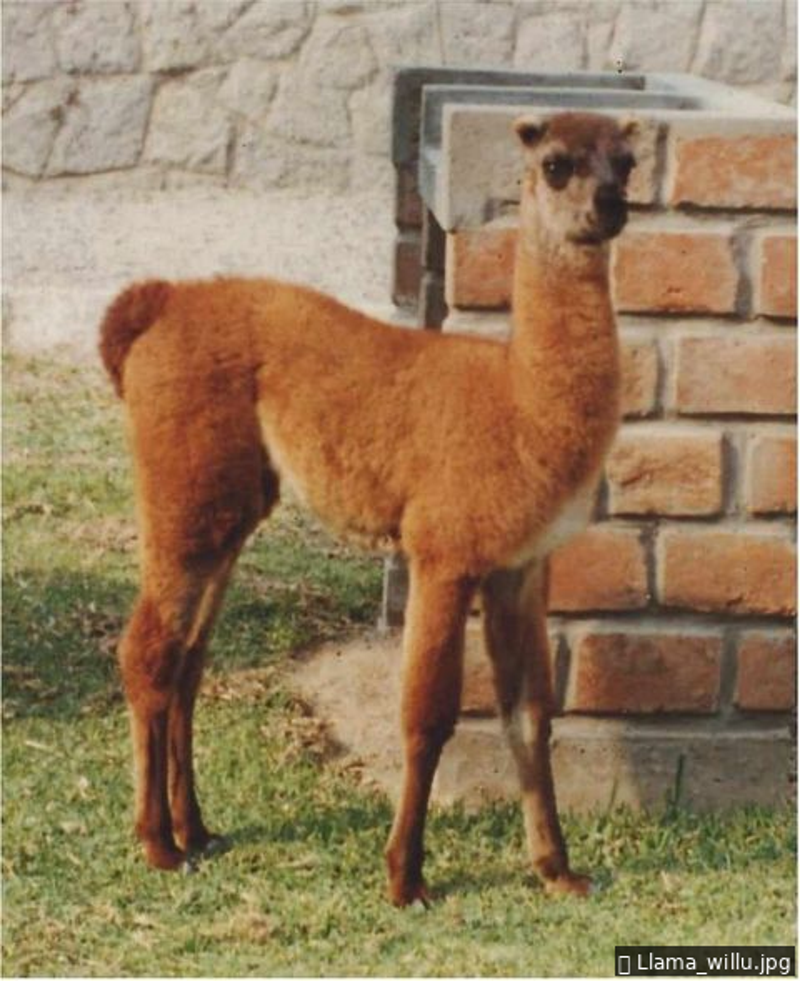

In [23]:
[AgnoImage(url=img) for img in att.images]

Next, we need to understand what agno's `agent.run()` method expects. We will study that in the next section.

## Understanding agno's Agent.run() Method

Let's examine how agno agents expect to receive images and text. For this,
we will look at the `agent.run` signature and understand what it expects.


In [24]:
from agno.agent import Agent as AgnoAgent
from agno.models.openai import OpenAIChat

# Create a simple agent to examine its interface
agent = AgnoAgent(
    model=OpenAIChat(id="gpt-4o-mini"),
    markdown=True,
)

# Let's see what parameters agent.run accepts
import inspect
sig = inspect.signature(agent.run)
print("agent.run() parameters:")
for param_name, param in sig.parameters.items():
    print(f"  {param_name}: {param.annotation if param.annotation != inspect.Parameter.empty else 'Any'}")

agent.run() parameters:
  message: Optional[Union[str, List, Dict, Message]]
  stream: Optional[bool]
  user_id: Optional[str]
  session_id: Optional[str]
  audio: Optional[Sequence[Audio]]
  images: Optional[Sequence[Image]]
  videos: Optional[Sequence[Video]]
  files: Optional[Sequence[File]]
  messages: Optional[Sequence[Union[Dict, Message]]]
  stream_intermediate_steps: Optional[bool]
  retries: Optional[int]
  knowledge_filters: Optional[Dict[str, Any]]
  kwargs: Any


From the agno documentation and our exploration, `agent.run()` accepts:
- **message** (str): The text prompt/question
- **images** (List[Image]): List of agno Image objects  
- **audio** (List[Audio]): List of agno Audio objects
- **stream** (bool): Whether to stream the response
- And other parameters...

We will test this:

In [25]:
agent = AgnoAgent(
    model=OpenAIChat(id="gpt-4.1-nano"),
    markdown=True,
)
att = Attachments("https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg",
                  "https://upload.wikimedia.org/wikipedia/commons/2/2c/Llama_willu.jpg")
res = agent.run(
    message="What do you see in this image?",
    images=[AgnoImage(url=img) for img in att.images],
    stream=False
)
res.content

'The first image shows the Golden Gate Bridge, a famous suspension bridge located in San Francisco, California. It spans the entrance to San Francisco Bay and is known for its distinctive orange-red color and impressive engineering.\n\nThe second image shows an animal that resembles a llama, but its head appears to be unusually small or altered, which might suggest it is a humorous or edited photo.'

Excellent! This confirms that agno expects a list of images.

What if we also want the text part of the prompt, which is automatically added by Attachments?

A basic way would be to simply add the text to the prompt, like this:

In [26]:
res = agent.run(
    message=f"Name the 2 things in the 2 images and tell me about the image metadata: {att.text}",
    images=[AgnoImage(url=img) for img in att.images],
    stream=False
)
res.content

'**Objects in the images:**\n\n1. The first image is of the **Golden Gate Bridge**, an iconic suspension bridge located in San Francisco, California.\n2. The second image is of a **Llama**, a domesticated South American camelid known for its wool and gentle nature.\n\n---\n\n**Metadata details:**\n\n### Image 1 (Golden Gate Bridge)\n- **Content Type:** image/jpeg\n- **Format:** JPEG\n- **Size:** 3264 × 2448 pixels\n- **Mode:** RGB\n- **Status Code:** 200\n\n### Image 2 (Llama)\n- **Content Type:** image/jpeg\n- **Format:** JPEG\n- **Size:** 480 × 589 pixels\n- **Mode:** RGB\n- **Status Code:** 200\n\nThis metadata indicates the images are in standard JPEG format, with the first image being significantly larger in resolution than the second. Both images are in the RGB color mode, which is typical for digital photographs.'

This works, but it's a bit tedious to have to always connect the attachments both to the prompt and
to the images.

By creating a dictionary with the keys 'message' and 'images', we can pass it to the `agent.run()`
method using the `**` operator.

Like this:


In [27]:
prompt = f"Name the 2 things in the 2 images and tell me about the image metadata:"
images = [AgnoImage(url=img) for img in att.images]

params = {
    "message": f"{prompt} {att.text}",
    "images": images,
}
res = res = agent.run(**params)
res.content

'### Names of the objects in the images:\n1. **First image:** Golden Gate Bridge\n2. **Second image:** Alpaca (or Llama)\n\n### Metadata details:\n#### First image (Golden Gate Bridge):\n- Content Type: image/jpeg\n- Resolution: 3264 × 2448 pixels\n- Format: JPEG\n- Mode: RGB\n- Status Code: 200 (indicating successful retrieval)\n\n#### Second image (Llama):\n- Content Type: image/jpeg\n- Resolution: 480 × 589 pixels\n- Format: JPEG\n- Mode: RGB\n- Status Code: 200 (indicating successful retrieval)'

We could easily turn that into a function:

In [28]:
def convert_attachments_to_agno(attachment, prompt=""):
    """Convert Attachments to agno Image objects."""
    images = [AgnoImage(url=img) for img in attachment.images]
    return {
        "message": f"{prompt} {attachment.text}",
        "images": images,
    }

params = convert_attachments_to_agno(att, "What do you see in this image?")
res = agent.run(**params)
res.content

"Here is a summary of the images:\n\n1. The first image is a famous photograph of the Golden Gate Bridge in San Francisco, California. It features the iconic orange-red suspension bridge against a scenic backdrop of water and sky, taken during daylight.\n\n2. The second image shows a young llama (or alpaca) standing outdoors next to a brick wall. The animal has a reddish-brown coat, with a slender neck and long legs, and is looking towards the camera.\n\nLet me know if you'd like more details!"

Great! Now all we have to do is mark it as an adapter:

In [30]:
from attachments.adapt import adapter
from attachments import Attachment, AttachmentCollection
from typing import Union, Dict, Any
@adapter
def custom_agno(input_obj: Union[Attachment, AttachmentCollection], prompt: str = "") -> Dict[str, Any]:
    return convert_attachments_to_agno(input_obj, prompt)

att = Attachments("https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg",
                  "https://upload.wikimedia.org/wikipedia/commons/2/2c/Llama_willu.jpg")

res = agent.run(**att.custom_agno("What do you see in this image?"))
res.content

"Certainly! Here's a summary of what is visible in each image:\n\n1. The first image is a famous photograph of the **Golden Gate Bridge** in San Francisco, California. It shows the iconic red-orange suspension bridge with its tall towers, cables, and the surrounding water and landscape in the background during a clear day.\n\n2. The second image depicts a **llama** standing outdoors against a brick wall. The llama has a reddish-brown coat, with a slender neck and long legs, and appears to be in a grassy area.\n\nLet me know if you'd like more detail!"

Success! We are now ready to pass any path and any file type to agno using Attachments.

Let's do a quick test with a PDF file:

In [ ]:
att = Attachments("https://upload.wikimedia.org/wikipedia/commons/f/f0/Strange_stories_%28microform%29_%28IA_cihm_05072%29.pdf[1-4]")
res = agent.run(**att.custom_agno("Summarize this document"))

In [32]:
Markdown(res.content)

The document is titled "Strange Stories" and appears to be a publication containing a collection of tales, possibly a book or an anthology. The first page advertises "The Piccadilly Novels," promoting popular stories by esteemed authors, many illustrated, priced at 3 shillings and 6 pence each. It lists numerous titles and authors, including Mrs. Alexander, James De Mille, Mrs. Annie Edwardes, Mrs. Lovett Cameron, and others. Some titles include "Maif, Wife, or Widow?", "Our Ladys B y v of T. Te I a," and "Pandurang Hari."

The second page continues listing stories and authors, including Charles Reade, Henry W. Lucy, Thomas Hardy, Wilkie Collins, James Payn, George MacDonald, and several others. It emphasizes the variety of stories and authors, showcasing both classic and contemporary writers, and mentions the affiliation with "Chatto and Windus, Piccadilly." 

The third page contains the title "Strange Stories," indicating the overall theme of the collection.

The last page appears to be a blank or very lightly marked page, possibly a cover or a finishing page for the scanned document.

**Overall summary:**  
The document is a catalog or cover page for a collection of "Strange Stories," featuring a variety of popular and classic authors, promoting a series of illustrated novels and tales sold at affordable prices by Chatto and Windus in Piccadilly.

And that's exactly it!


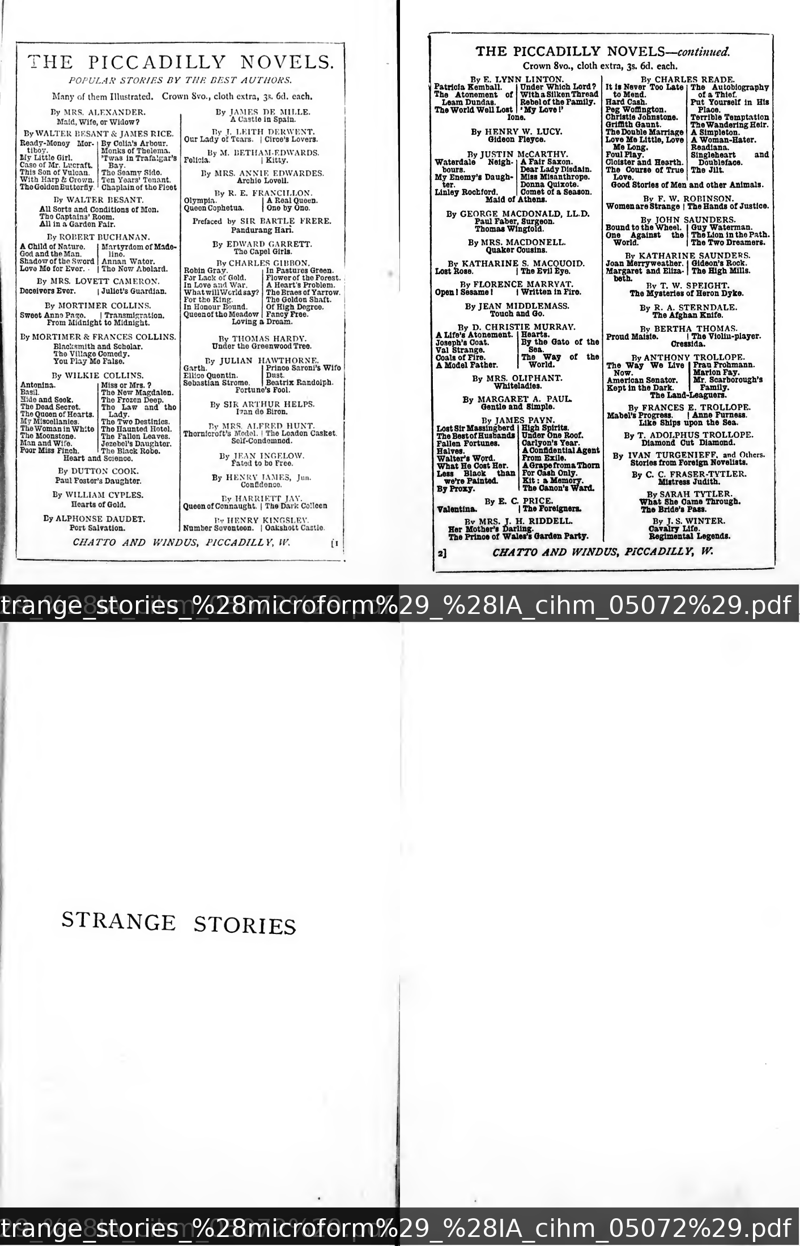

In [33]:
from IPython.display import HTML
HTML(f"<img src='{att.images[0]}'>")

## Conclusion

We have now created an adapter that allows us to use Attachments with agno.

This is a simple example, but it shows the power of adapters.

## ps
Agno is already supported as an adapter, so you can use Attachments("path/to/file").agno()